In [1]:
import math
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.primitives import StatevectorSampler
import numpy as np
import itertools

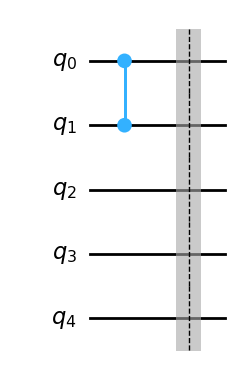

In [2]:
oracle = QuantumCircuit(5)
oracle.cz(0, 1)
oracle.barrier()
oracle.draw(output="mpl", style="iqp")

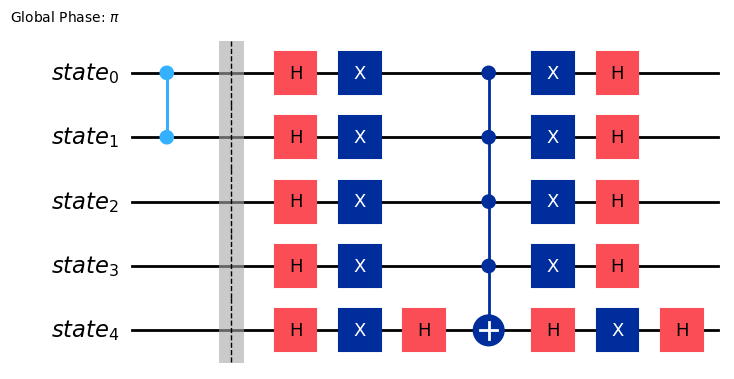

In [3]:
grover = GroverOperator(oracle)
grover.decompose().draw(output="mpl", style="iqp")

In [4]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(8 / 2**grover.num_qubits)))
)
optimal_num_iterations

1

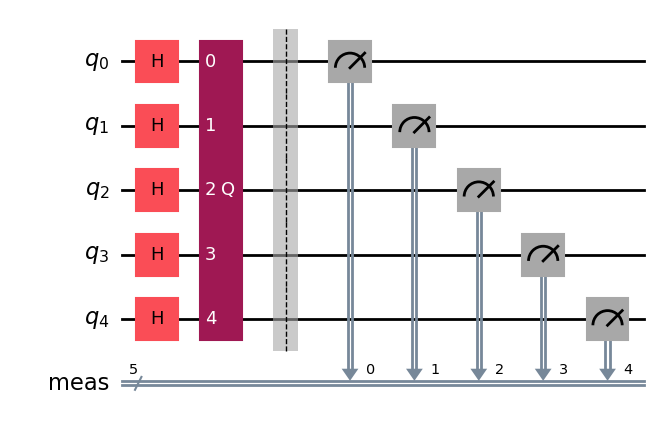

In [5]:
qc = QuantumCircuit(grover.num_qubits)
qc.h(range(grover.num_qubits))
qc.compose(grover.power(optimal_num_iterations), inplace=True)
qc.measure_all()
qc.draw(output="mpl", style="iqp")

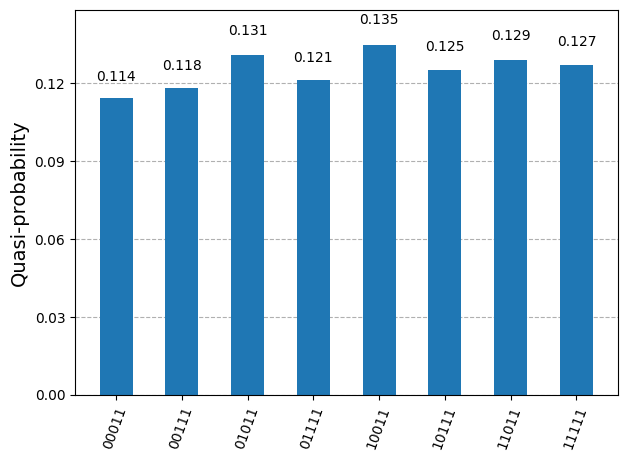

In [6]:
sampler = StatevectorSampler()
result = sampler.run([qc]).result()
dist = result[0].data.meas.get_counts()
plot_distribution(dist)

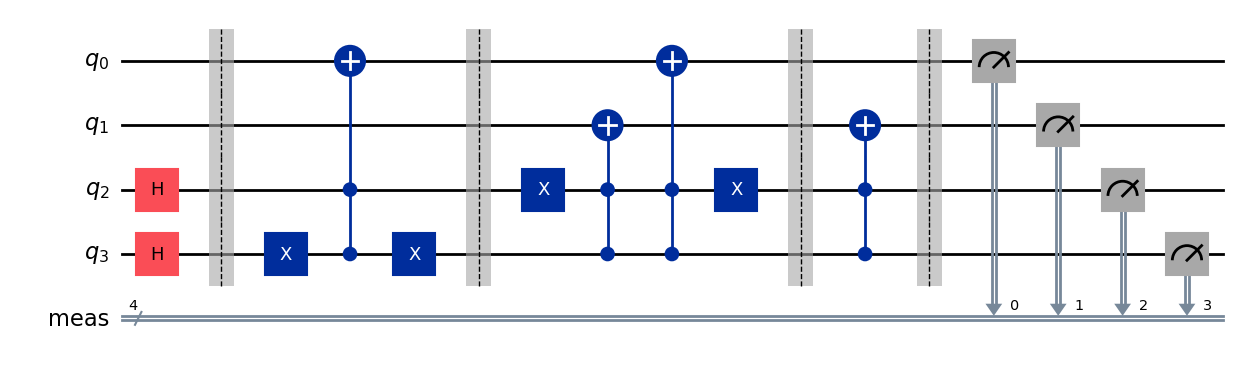

In [32]:
# initializer
# encode [0000, 0101, 1011, 1110]
initializer = QuantumCircuit(4)
initializer.h([2, 3])
initializer.barrier()

initializer.x(3)
initializer.ccx(3, 2, 0)
initializer.x(3)
initializer.barrier() # without this the 2nd becomes 0100

initializer.x(2)
initializer.ccx(3, 2, 1)
initializer.ccx(3, 2, 0)
initializer.x(2)
initializer.barrier() # without this the 3rd becomes 1000

initializer.ccx(3, 2, 1) # without this the 4th becomes 1100

initializer.measure_all()
initializer.draw(output="mpl", style="iqp")

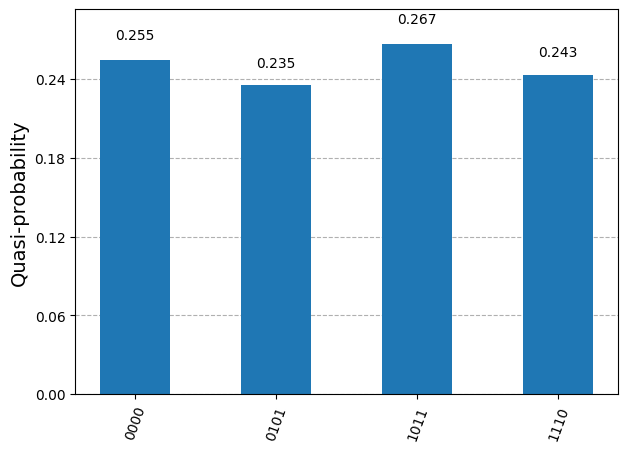

In [33]:
sampler = StatevectorSampler()
result = sampler.run([initializer]).result()
dist = result[0].data.meas.get_counts()
plot_distribution(dist)

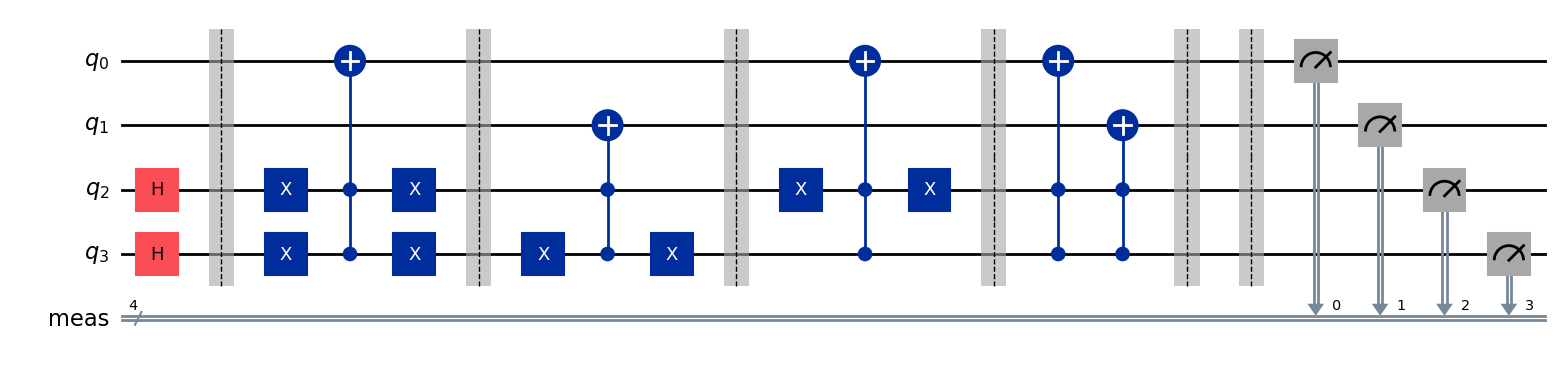

In [34]:
# going to encode [0001, 0110, 1001, 1111]
# x before and after the zeros in the first two, toffoli on the ones in the last two

encoder = QuantumCircuit(4)
encoder.h([2, 3])
encoder.barrier()

encoder.x([2, 3])
encoder.ccx(2, 3, 0)
encoder.x([2, 3])
encoder.barrier()

encoder.x([3])
encoder.ccx(2, 3, 1)
encoder.x([3])
encoder.barrier()

encoder.x([2])
encoder.ccx(2, 3, 0)
encoder.x([2])
encoder.barrier()

encoder.ccx(2, 3, 0)
encoder.ccx(2, 3, 1)
encoder.barrier()

encoder.measure_all()
encoder.draw(output="mpl", style="iqp")

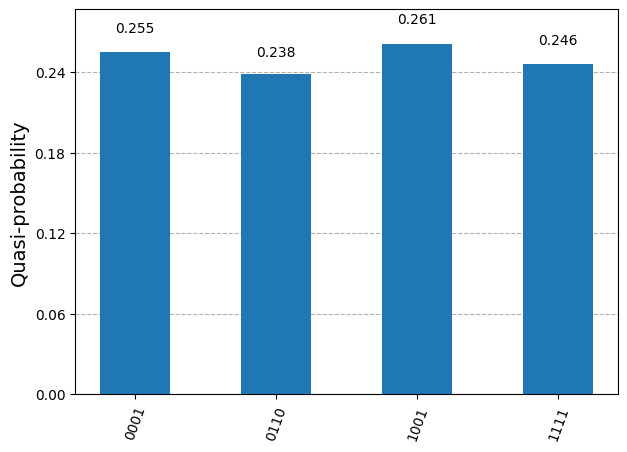

In [35]:
sampler = StatevectorSampler()
result = sampler.run([encoder]).result()
dist = result[0].data.meas.get_counts()
plot_distribution(dist)

In [48]:
def n_encoder(n: int, states: list[str]) -> QuantumCircuit:
    """
    Put n qubits into an equal superposition of states
    """
    encoder = QuantumCircuit(n)

    n_control_bits = math.floor(math.log2(len(states)))
    control_bits = [i for i in range(n-1, n-1-n_control_bits, -1)]
    
    encoder.h(control_bits)
    encoder.barrier()

    for state in states:
        print(state)
        state = state[::-1]

        print(state[:n - n_control_bits])
        if not '1' in state[:n - n_control_bits]:
            continue

        x_needed = len([cb for cb in control_bits if state[cb] == '0']) > 0
        if x_needed:
            encoder.x([cb for cb in control_bits if state[cb] == '0'])

        for j, qb in enumerate(state[:n - n_control_bits]):
            if qb == '1':
                encoder.mcx(control_bits, j)

        if x_needed:
            encoder.x([cb for cb in control_bits if state[cb] == '0'])
        
        encoder.barrier()
        
    return encoder


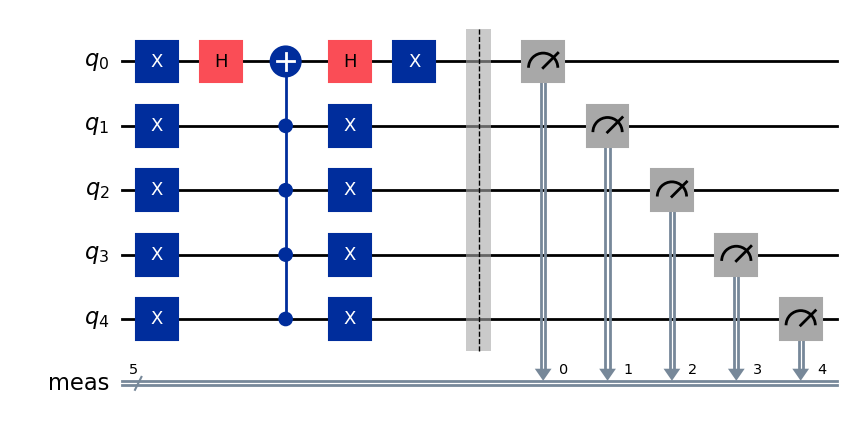

In [6]:
zor = QuantumCircuit(5)
#zor.h([i for i in range(5)])
zor.x([i for i in range(5)])
zor.h(0)
zor.mcx([i for i in range(1, 5)], 0)
zor.h(0)
zor.x([i for i in range(5)])
#zor.h([i for i in range(5)])

zor.measure_all()
zor.draw(output="mpl", style="iqp")

00010
01
00110
01
01010
01
01111
11
10000
00
10100
00
11000
00
11101
10


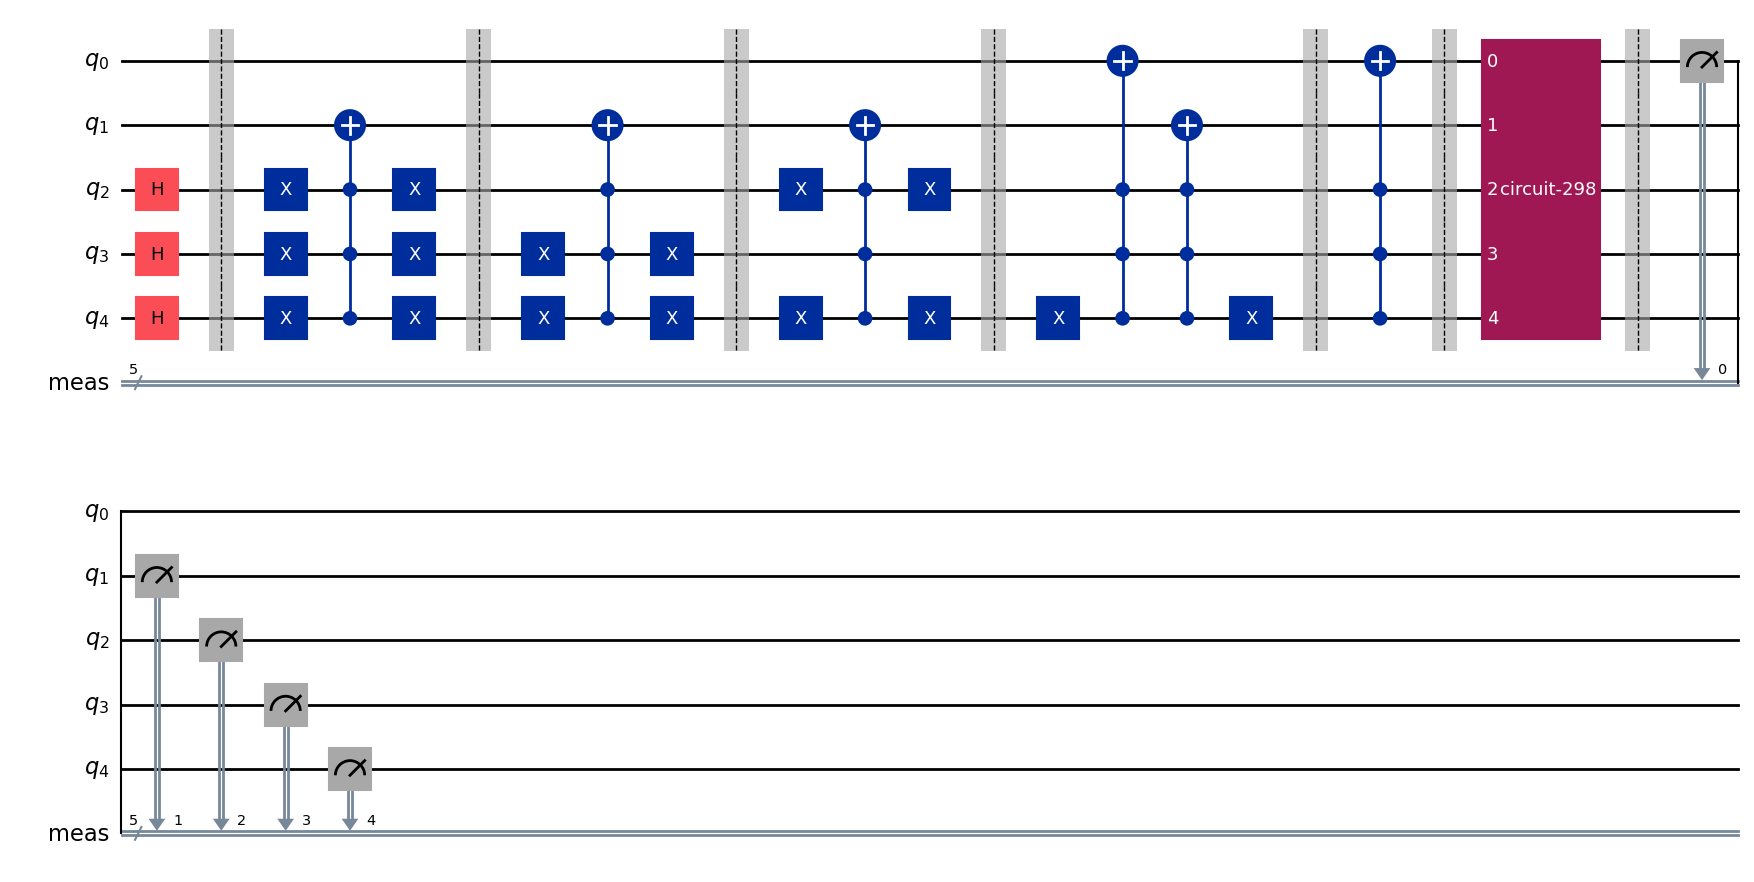

In [49]:
n_qubits = 5
states = ['00010', '00110', '01010', '01111', '10000', '10100', '11000', '11101']

circuit = QuantumCircuit(n_qubits)

circuit.compose(n_encoder(n_qubits, states), inplace=True)
#circuit.barrier()
#circuit.barrier()

oracle = QuantumCircuit(n_qubits)
oracle.cz(0, 1)

zor = QuantumCircuit(n_qubits)
zor.x([i for i in range(n_qubits)])
zor.h(0)
zor.mcx([i for i in range(1, n_qubits)], 0)
zor.h(0)
zor.x([i for i in range(n_qubits)])

grover_block = QuantumCircuit(n_qubits)
grover_block.compose(oracle, inplace=True)
grover_block.barrier()
grover_block.h([i for i in range(n_qubits)])
grover_block.barrier()
grover_block.compose(zor, inplace=True)
grover_block.barrier()
grover_block.h([i for i in range(n_qubits)])
grover_block.barrier()
grover_block.barrier()

optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(8 / 2**n_qubits)))
)

circuit.compose(grover_block.power(optimal_num_iterations), inplace=True)

circuit.measure_all()
circuit.draw(output="mpl", style="iqp")

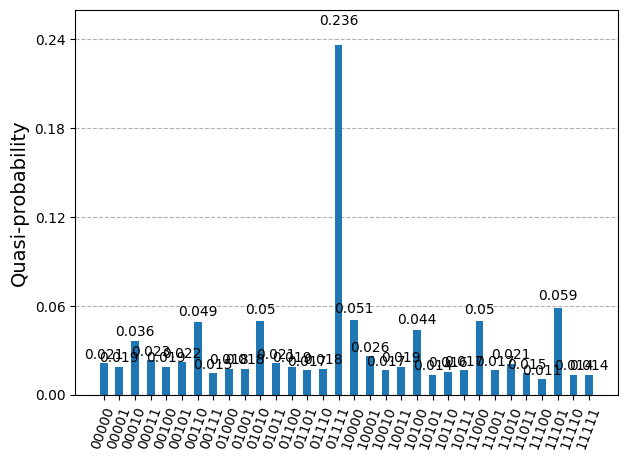

In [50]:
sampler = StatevectorSampler()
result = sampler.run([circuit]).result()
dist = result[0].data.meas.get_counts()
plot_distribution(dist)

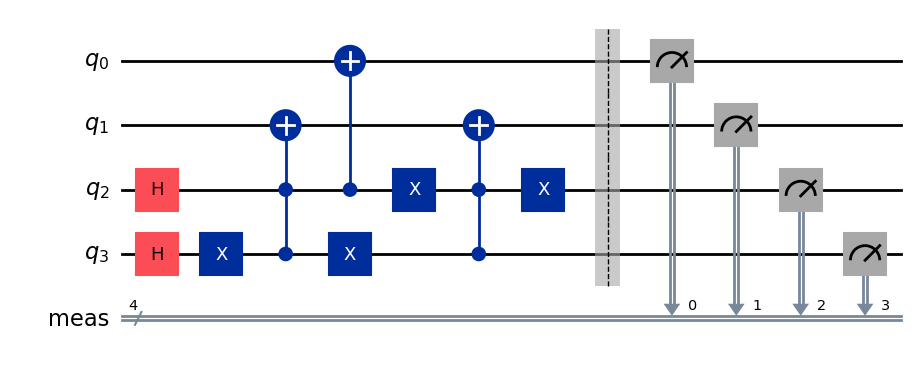

In [6]:
# encoding version IV. states: 0000, 0101, 1011, 1110
"""
e = QuantumCircuit(4)
e.h([2, 3])

e.x(3)
e.ccx(3, 2, 0)
e.x(3)

e.x(2)
e.ccx(3, 2, 0)
e.x(2)

e.cx(3, 1)

"""

# states: 0000, 0111, 1010, 1101

e = QuantumCircuit(4)
e.h([2, 3])

e.x(3)
e.ccx(3, 2, 1)
e.x(3)

e.cx(2, 0)

e.x(2)
e.ccx(3, 2, 1)
e.x(2)

e.measure_all()
e.draw(output="mpl", style="iqp")


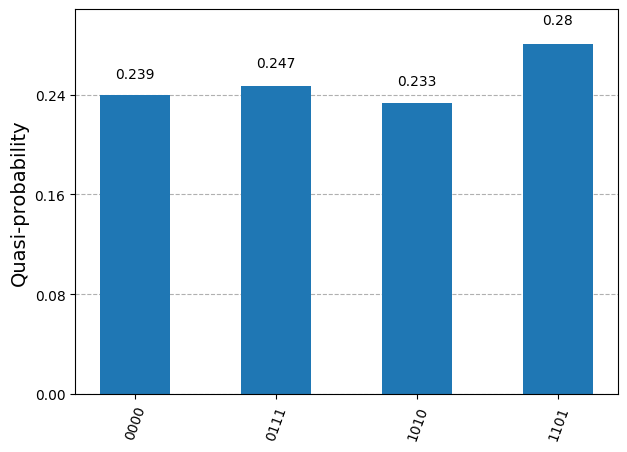

In [7]:

sampler = StatevectorSampler()
result = sampler.run([e]).result()
dist = result[0].data.meas.get_counts()
plot_distribution(dist)

In [37]:
def _get_cnots(states: list[str], n_qubits: int, n_control_bits: int) -> set[tuple[int]]:
    cnots = set()

    for i, s1 in enumerate(states):
        # check if EVERY string that has a 1 in a certain position in the control section has a 1 in a same position in the other section
        # for every string, for every bit in the target section that is 1, check if there's a similarity in the control section

        control_ones_indexes = [i for i, qb in enumerate(s1[:n_control_bits]) if qb == '1']
        target_ones_indexes = [i + n_control_bits for i, qb in enumerate(s1[n_control_bits:]) if qb == '1']
        print(s1, control_ones_indexes, target_ones_indexes)
        for ci in control_ones_indexes:
            have_1_in_control_position = [state for state in states if state != s1 and state[ci] == '1']
            # if each of these have a common target 1 then OK
            for ti in target_ones_indexes:
                have_1_in_target_position = [state for state in have_1_in_control_position if state[ti] == '1']
                if len(have_1_in_control_position) == len(have_1_in_target_position):
                    cnots.add((n_qubits - ci - 1, n_qubits - ti - 1))
    return cnots

def _get_toffolis(states: list[str], n_qubits: int, n_control_bits: int) -> set[tuple[int]]:
    toffolis = set()

    for i, s1 in enumerate(states):
        control_ones_indexes = [i for i, qb in enumerate(s1[:n_control_bits]) if qb == '1']
        if len(control_ones_indexes) < 2:
            continue

        control_ones_indexes_couples = list(itertools.combinations(control_ones_indexes, 2))

        target_ones_indexes = [i + n_control_bits for i, qb in enumerate(s1[n_control_bits:]) if qb == '1']
        #print(s1, control_ones_indexes, target_ones_indexes)
        for ci in control_ones_indexes_couples:
            have_1_in_couple_positions = [state for state in states if state != s1 and state[ci[0]] == '1' and state[ci[1]] == '1']
            for ti in target_ones_indexes:
                have_1_in_target_position = [state for state in have_1_in_couple_positions if state[ti] == '1']
                if len(have_1_in_couple_positions) == len(have_1_in_target_position):
                    toffolis.add((n_qubits - ci[0] - 1, n_qubits - ci[1] - 1, n_qubits - ti - 1))
    return toffolis



def _get_mcxs(states: list[str], n_qubits: int, n_control_bits: int, m: int) -> tuple[set[tuple[int]]]:
    mcxs_1 = set()
    mcxs_0 = set()

    for i, s in enumerate(states): # control ones
        control_ones_indexes = [i for i, qb in enumerate(s[:n_control_bits]) if qb == '1']
        if len(control_ones_indexes) < m:
            continue

        control_ones_indexes_groups = list(itertools.combinations(control_ones_indexes, m))

        target_ones_indexes = [i + n_control_bits for i, qb in enumerate(s[n_control_bits:]) if qb == '1']
        #print(s1, control_ones_indexes, target_ones_indexes)
        for gi in control_ones_indexes_groups:
            have_1_in_group_positions = [state for state in states if state != s and all([state[k] == '1' for k in gi])]
            for ti in target_ones_indexes:
                have_1_in_target_position = [state for state in have_1_in_group_positions if state[ti] == '1']
                if len(have_1_in_group_positions) == len(have_1_in_target_position):
                    #mcx = [n_qubits - k - 1 for k in gi]
                    #mcx.append(n_qubits - ti - 1)
                    mcx = [k for k in gi]
                    mcx.append(ti)
                    mcxs_1.add(tuple(mcx))

    for i, s in enumerate(states): # control zeros
        control_zeros_indexes = [i for i, qb in enumerate(s[:n_control_bits]) if qb == '0']
        if len(control_zeros_indexes) < m:
            continue

        control_zeros_indexes_groups = list(itertools.combinations(control_zeros_indexes, m))

        target_ones_indexes = [i + n_control_bits for i, qb in enumerate(s[n_control_bits:]) if qb == '1']
        for gi in control_zeros_indexes_groups:
            have_0_in_group_positions = [state for state in states if state != s and all([state[k] == '0' for k in gi])]
            for ti in target_ones_indexes:
                have_1_in_target_position = [state for state in have_0_in_group_positions if state[ti] == '1']
                if len(have_0_in_group_positions) == len(have_1_in_target_position):
                    mcx = [k for k in gi]
                    mcx.append(ti)
                    mcxs_0.add(tuple(mcx))
    return mcxs_1, mcxs_0
        

In [39]:
def _2_common_features(states: list[str], n_qubits: int, n_control_bits: int, encoder: QuantumCircuit) -> list[str]:
    cnots = _get_cnots(states, n_qubits, n_control_bits)

    states = [s[::-1] for s in states]

    for cx in cnots:
        encoder.cx(cx[0], cx[1])
        for i, s in enumerate(states):
            if s[cx[0]] == '1':
                s = list(s)
                s[cx[1]] = '0'
                states[i] = ''.join(s)
    
    return states

def _3_common_features(states: list[str], n_qubits: int, n_control_bits: int, encoder: QuantumCircuit) -> list[str]:
    toffolis = _get_toffolis(states, n_qubits, n_control_bits)

    states = [s[::-1] for s in states] ##############################################

    for t in toffolis:
        encoder.ccx(t[0], t[1], t[2])
        for i, s in enumerate(states):
            if s[t[0]] == '1' and s[t[1]] == '1':
                s = list(s)
                s[t[2]] = '0'
                states[i] = ''.join(s)
    
    return states


def _common_features(states: list[str], n_qubits: int, n_control_bits: int, encoder: QuantumCircuit) -> list[str]:
    n_controls_list = list(range(1, n_control_bits)) + list(range(1, n_control_bits))[::-1]
    for n_controls in n_controls_list:
        mcxs_1, mcxs_0 = _get_mcxs(states, n_qubits, n_control_bits, n_controls)

        #states = [s[::-1] for s in states]

        for m in mcxs_1:
            #print(m, m[:-1])
            m = list(m)

            #encoder.mcx(m[:-1], m[-1])
            m_qisqit_indexing = [n_qubits - 1 - j for j in m]
            encoder.mcx(m_qisqit_indexing[:-1], m_qisqit_indexing[-1])

            for i, s in enumerate(states):
                are_control_ones = [s[j] == '1' for j in m[:-1]]
                if all(are_control_ones):
                    s = list(s)
                    s[m[-1]] = '0'
                    states[i] = ''.join(s)

    
        for m in mcxs_0:
            m = list(m)

            #encoder.mcx(m[:-1], m[-1])
            m_qisqit_indexing = [n_qubits - 1 - j for j in m]
            encoder.x(m_qisqit_indexing[:-1])
            encoder.mcx(m_qisqit_indexing[:-1], m_qisqit_indexing[-1])
            encoder.x(m_qisqit_indexing[:-1])

            for i, s in enumerate(states):
                are_control_zeros = [s[j] == '0' for j in m[:-1]]
                if all(are_control_zeros):
                    s = list(s)
                    s[m[-1]] = '0'
                    states[i] = ''.join(s)
    
    return states



#_common_features(['0000', '0111', '1010', '1101'])
#_common_features(['0000', '0101', '1011', '1110'])

In [40]:
def n_encoder(n: int, states: list[str]) -> QuantumCircuit:
    """
    Put n qubits into an equal superposition of states
    """
    encoder = QuantumCircuit(n)

    n_control_bits = math.floor(math.log2(len(states)))
    control_bits = [i for i in range(n-1, n-1-n_control_bits, -1)]
    
    encoder.h(control_bits)
    encoder.barrier()

    #states = _common_features(states, n, n_control_bits, encoder)
    states = _common_features(states, n, n_control_bits, encoder)

    encoder.barrier()

    states = [s[::-1] for s in states]
    for state in states:

        if not '1' in state[:n - n_control_bits]:
            continue

        x_needed = len([cb for cb in control_bits if state[cb] == '0']) > 0
        if x_needed:
            encoder.x([cb for cb in control_bits if state[cb] == '0'])

        for j, qb in enumerate(state[:n - n_control_bits]):
            if qb == '1':
                encoder.mcx(control_bits, j)

        if x_needed:
            encoder.x([cb for cb in control_bits if state[cb] == '0'])
        
        encoder.barrier()
        
    return encoder

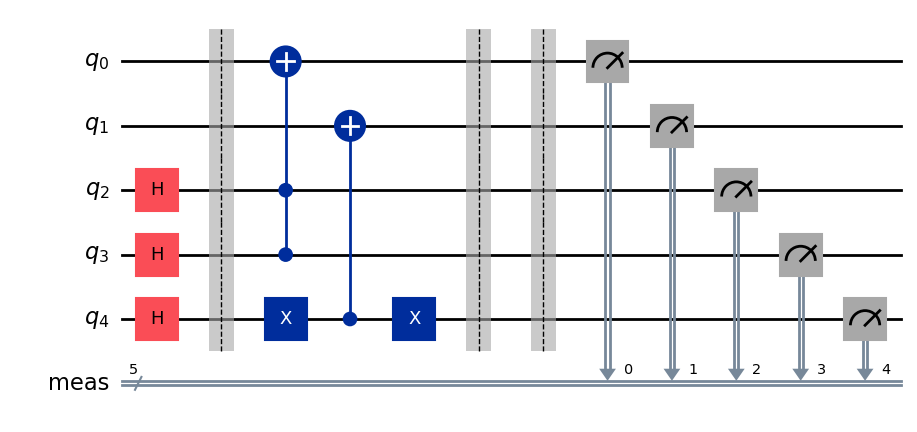

In [41]:
#e = n_encoder(4, ['0000', '0111', '1010', '1101'])
e = n_encoder(5, ['00010', '00110', '01010', '01111', '10000', '10100', '11000', '11101'])

e.measure_all()
e.draw(output="mpl", style="iqp")

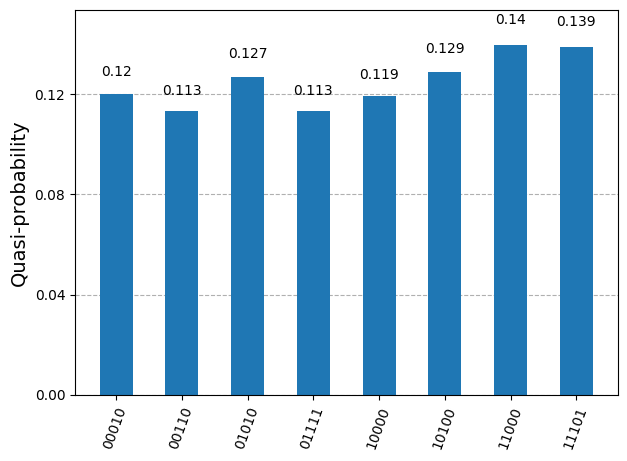

In [42]:
sampler = StatevectorSampler()
result = sampler.run([e]).result()
dist = result[0].data.meas.get_counts()
plot_distribution(dist)

In [ ]:
# the control bits select the index of the state to modify, the target modifies the muon count